In [1]:
# Bag of Words Meets Bags of Popcorn

!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c sf-crime

!kaggle competitions download -c word2vec-nlp-tutorial # Rules에서 허락 필요

!unzip labeledTrainData.tsv.zip
!unzip unlabeledTrainData.tsv.zip
!unzip testData.tsv.zip

import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

Saving kaggle.json to kaggle.json
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
testData.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)
labeledTrainData.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)
unlabeledTrainData.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
Archive:  labeledTrainData.tsv.zip
replace labeledTrainData.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: labeledTrainData.tsv    
Archive:  unlabeledTrainData.tsv.zip
replace unlabeledTrainData.tsv? [y]es, [n]o, [A]ll, [N]one, [r]

In [2]:
train = pd.read_csv('/content/labeledTrainData.tsv',sep='\t') # tsv는 탭으로 띄어진 파일
unlabeledtrain = pd.read_csv('/content/unlabeledTrainData.tsv',sep='\t', error_bad_lines=False)
test = pd.read_csv('/content/testData.tsv',sep='\t')
sampleSubmission = pd.read_csv('/content/sampleSubmission.csv')

train.info()

b'Skipping line 43043: expected 2 fields, saw 3\n'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [3]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
unlabeledtrain.head()

,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."


In [5]:
test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [6]:
print(train["review"][0])

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally star

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
import re
from nltk.corpus import stopwords

def preprocessing(data):
  data = re.sub('[^a-zA-Z]',' ',data)
  data = re.sub('br','',data).split()
  data = [w for w in data if not w in stopwords.words('english')]
  return ' '.join(data)

train_pre = []

for review in train['review']:
    train_pre.append(preprocessing(review))

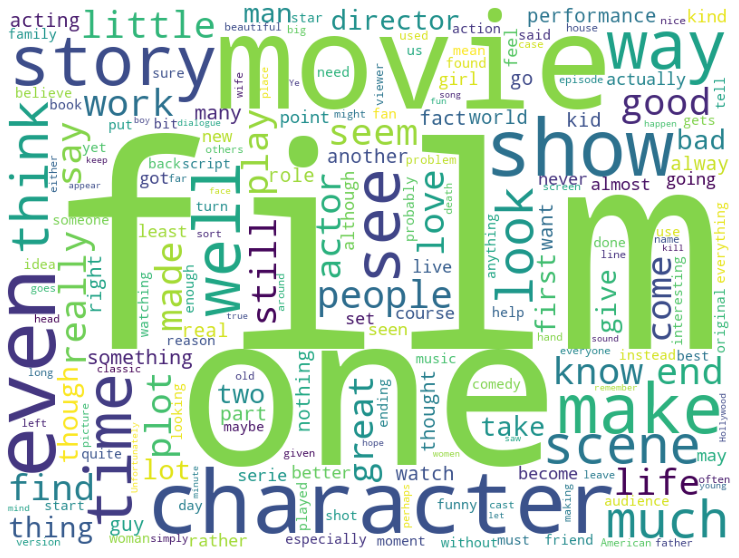

CPU times: user 24.2 s, sys: 942 ms, total: 25.1 s
Wall time: 25.1 s


In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
  
%time displayWordCloud(' '.join(train_pre))

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

train_feature = vectorizer.fit_transform(train_pre)
train_feature = train_feature.toarray()
vocab = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
# 각각의 단어의 개수를 더하기
dist = np.sum(train_feature, axis=0)

# 각각의 단어와 개수를 함께 보여주기
for tag, count in zip(vocab, dist):
    print(count, tag)

84 aaham
187 abandoned
125 abc
108 abilities
454 ability
1259 able
244 about
116 absence
83 absent
352 absolute
1485 absolutely
306 absurd
192 abuse
91 abusive
98 abysmal
297 academy
485 accent
203 accents
300 accept
130 acceptable
144 accepted
92 access
318 accident
200 accidentally
88 accompanied
124 accomplished
296 according
186 account
81 accuracy
284 accurate
123 accused
179 achieve
139 achieved
124 achievement
90 acid
971 across
1251 act
660 acted
6494 acting
3355 action
311 actions
83 activities
2389 actor
4488 actors
1219 actress
369 actresses
394 acts
793 actual
4240 actually
149 ad
303 adam
98 adams
454 adaptation
154 adapted
810 add
440 added
166 adding
347 addition
337 adds
113 adequate
124 admire
621 admit
134 admittedly
101 adorable
511 adult
376 adults
101 advance
90 advanced
153 advantage
510 adventure
204 adventures
91 advertising
259 advice
90 advise
346 affair
93 affect
113 affected
104 afford
126 aforementioned
343 afraid
212 africa
255 african
1599 after
187 after

In [12]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100) 

forest = forest.fit(train_feature, train["sentiment"] )

In [13]:
# 테스트 데이터에 대한 전처리

test_pre = []

for review in test['review']:
    test_pre.append(preprocessing(review))

test_feature = vectorizer.transform(test_pre)
test_feature = test_feature.toarray()

In [14]:
result = forest.predict(test_feature)

output = pd.DataFrame(data={"id":test["id"], "sentiment":result} )

# 데이터 프레임을 csv파일로 저장
output.to_csv("submission.csv", index=False, quoting=3 )

In [16]:
!kaggle competitions submit -c word2vec-nlp-tutorial -f submission.csv -m "Message"

100% 227k/227k [00:01<00:00, 144kB/s]
Successfully submitted to Bag of Words Meets Bags of Popcorn